In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

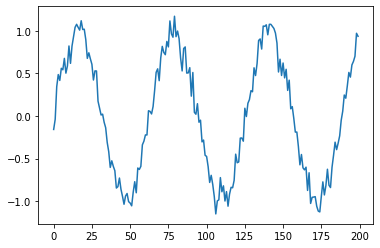

In [13]:
# Make the data (again, synthetic data so we can study the behavior of the model under different controlled circumstances)
series = np.sin(.1*np.arange(200)) + np.random.randn(200)*0.1 # noise

plt.plot(series)
plt.show()

In [14]:
# Build the dataset
# Use T = 10 previous timesteps to predict next ones
T = 10
X = []
Y = []
for t in range(len(series) - T):
  '''
  e.g. of what this is doing:
  say series is [1,2,3,4,5] and T is 2.
  This loop will give us the following matrices:
  X = [
    [1,2],
    [2,3],
    [3,4]
  ]
  Y = [[3, 4, 5]]
  Essentially, we're building an NxT=Nx2 matrix for the input,
  and a 1D array of length N for the labels, where N=5-(T+1)+1=5-3+1=3.
  this is setting up an autoregressive model, so we can predict
  future values based on the previous values T values
  '''
  x = series[t:t+T] # t up to t+T (this is an array)
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (190, 10) Y.shape (190,)


In [15]:
# Build the autoregressive model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1)
)
r = model.fit(
  X[:-N//2], Y[:-N//2], # train on first half (important because we shouldnt use future points in training)
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]) # test on second half
)

Epoch 1/80


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


3/3 [==============================] - 0s 71ms/step - loss: 0.2259 - val_loss: 0.1019
Epoch 2/80
3/3 [==============================] - 0s 15ms/step - loss: 0.1998 - val_loss: 0.0887
Epoch 3/80
3/3 [==============================] - 0s 25ms/step - loss: 0.0682 - val_loss: 0.1066
Epoch 4/80
3/3 [==============================] - 0s 30ms/step - loss: 0.1140 - val_loss: 0.0290
Epoch 5/80
3/3 [==============================] - 0s 31ms/step - loss: 0.0418 - val_loss: 0.0780
Epoch 6/80
3/3 [==============================] - 0s 39ms/step - loss: 0.0684 - val_loss: 0.0300
Epoch 7/80
3/3 [==============================] - 0s 45ms/step - loss: 0.0364 - val_loss: 0.0583
Epoch 8/80
3/3 [==============================] - 0s 39ms/step - loss: 0.0541 - val_loss: 0.0262
Epoch 9/80
3/3 [==============================] - 0s 65ms/step - loss: 0.0335 - val_loss: 0.0422
Epoch 10/80
3/3 [==============================] - 0s 57ms/step - loss: 0.0399 - val_loss: 0.0227
Epoch 11/80
3/3 [=======================

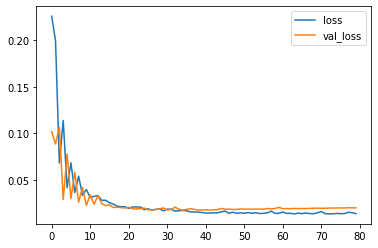

In [16]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [17]:
# "Wrong" forecast method using true targets
validation_target = Y[-N//2:] # 2nd half of Y
validation_predictions = []
# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
  # Input to predict() must be a 2D array, but X is a 2D array, so X[i] is a 1D array of length T
  # So reshape the array to 1xT (1 sample with T features)
  # Also, predict() gives us an NxK output. N = K = 1, so we get a 1x1 2D array
  # So index the array at 0,0
  p = model.predict(X[i].reshape(1, -1))[0,0]
  i += 1

  # update predictions list
  validation_predictions.append(p)

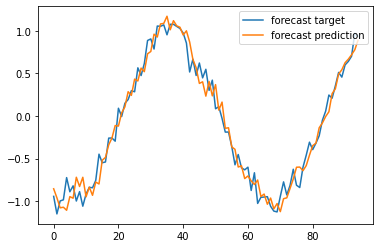

In [18]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [19]:
# Proper way to forecast (use only self-predictions for future predictions)
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0,0]
  validation_predictions.append(p)

  # make the new input (shift all values of array to left and add new prediction to the end)
  last_x = np.roll(last_x, -1) # shift all 1 spot to left
  last_x[-1] = p # original first val was shifted to other side, but we replace with p, our prediction

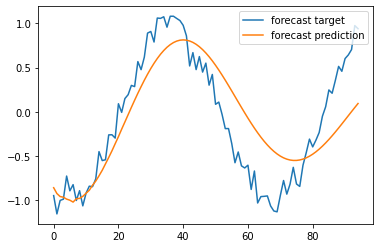

In [20]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
# model learns that the true underlying function is smoothe